In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.datasets as datasets
import torch.utils.data as data
import os
import torch
from tqdm import tqdm

rng = np.random.default_rng()

In [2]:
weights = ResNet50_Weights.DEFAULT
model = resnet50(pretrained = True)
model.eval()

# For Preprocessing the input images

preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

/home/dinesh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dinesh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
data_dir = 'tiny-224/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=preprocess) 
                  for x in ['train','test']}
dataloaders = {x: data.DataLoader(image_datasets[x], batch_size=1, shuffle=True, num_workers=8)
                  for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

In [ ]:
TRAIN_SIZE = 100000
TEST_SIZE = int(10 * TRAIN_SIZE/100)
DIM = 1000
THRESHOLD = 0.001
trainset = np.empty((TRAIN_SIZE, 224, 224, 3), dtype=np.uint8)
testset = np.empty((TEST_SIZE, 224, 224, 3), dtype= np.uint8)
train_labels = []
test_labels = []
train_prediction = np.empty((TRAIN_SIZE, DIM), dtype =np.float32)
test_prediction = np.empty((TEST_SIZE, DIM), dtype=np.float32)

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

for i, data in tqdm(enumerate(dataloaders['train'], 0)):
    with torch.no_grad():
        if i<TRAIN_SIZE:
            inputs, labels  = data
            prediction = model(inputs).squeeze(0).softmax(0)
            # vects = act_maps.reshape(2048)

            img_unnormalized = inputs.squeeze(0).clone()
            for j in range(3):
                img_unnormalized[j] = img_unnormalized[j] * std[j] + mean[j]
            
            img_unnormalized = img_unnormalized.permute(1,2,0).detach().numpy()
            img_unnormalized = img_unnormalized - np.min(img_unnormalized)
            img_unnormalized = img_unnormalized / np.max(img_unnormalized)
            img_unnormalized = img_unnormalized * 255
 
            trainset[i] = img_unnormalized.astype(np.uint8)
            
            # class_id = prediction.argmax().item()
            # score = prediction[class_id].item()
            # category_name = weights.meta["categories"][class_id]
            # train_labels.append(f"{category_name}: {100 * score:.1f}%")
            

            train_labels.append(labels.item())

            pred = prediction.detach().numpy()
            pred[pred < THRESHOLD] = 0

            train_prediction[i] = pred
        else:
            break

In [ ]:
for i, data in tqdm(enumerate(dataloaders['test'], 0)):
    with torch.no_grad():
        if i<TEST_SIZE:
            inputs, labels  = data
            prediction = model(inputs).squeeze(0).softmax(0)
            img_unnormalized = inputs.squeeze(0).clone()
            for j in range(3):
                img_unnormalized[j] = img_unnormalized[j] * std[j] + mean[j]
            img_unnormalized = img_unnormalized.permute(1,2,0).detach().numpy()
            img_unnormalized = img_unnormalized - np.min(img_unnormalized)
            img_unnormalized = img_unnormalized / np.max(img_unnormalized)
            img_unnormalized = img_unnormalized * 255
 
            testset[i] = img_unnormalized.astype(np.uint8)

            class_id = prediction.argmax().item()
            category_name = weights.meta["categories"][class_id]
            test_labels.append(labels.item())

            pred = prediction.detach().numpy()
            pred[pred < THRESHOLD] = 0

            test_prediction[i] = pred
        else:
            break

10000it [08:25, 19.77it/s]


(100000, 1000)
(100000, 224, 224, 3)
(10000, 1000)
(10000, 224, 224, 3)


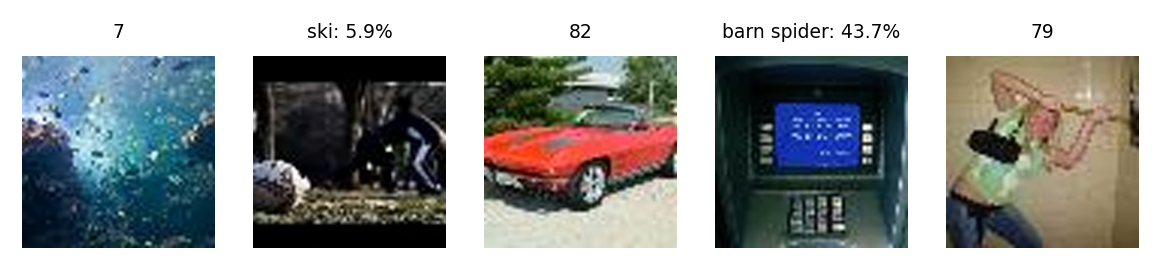

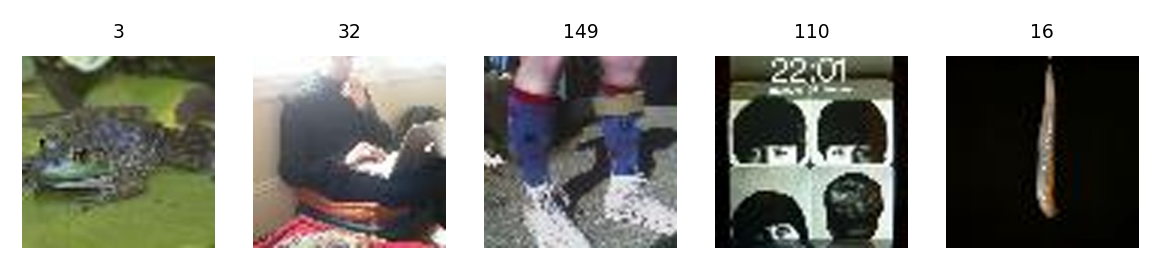

In [ ]:
print(train_prediction.shape)
print(trainset.shape)
print(test_prediction.shape)
print(testset.shape)

f, axarr = plt.subplots(1, 5)
f.dpi = 225

index = rng.integers(low=0, high=TRAIN_SIZE, size=5)
for i in range(5):
    axarr[i].set_title(train_labels[index[i]], fontsize = 6)
    axarr[i].axis("off")
    axarr[i].imshow(trainset[index[i]])

plt.show()

f, axarr = plt.subplots(1, 5)
f.dpi = 225

index = rng.integers(low=0, high=TEST_SIZE, size=5)
for i in range(5):
    axarr[i].set_title(test_labels[index[i]], fontsize = 6)
    axarr[i].axis("off")
    axarr[i].imshow(testset[index[i]])

plt.show()

In [ ]:
import pickle

# write list to binary file
def write_list(a_list, file):
    # store list in binary file so 'wb' mode
    with open(file, 'wb') as fp:
        pickle.dump(a_list, fp)
        print('Done writing list into a binary file')

# Read list to memory
def read_list(list_name):
    # for reading also binary mode is important
    with open(list_name, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list

In [ ]:
np.save('train_prediction', train_prediction)
np.save('test_prediction', test_prediction)
np.save('trainset', trainset)
np.save('testset', testset)

write_list(train_labels, 'train_labels')
write_list(test_labels, 'test_labels')

Done writing list into a binary file
Done writing list into a binary file
